<a href="https://colab.research.google.com/github/pmb06d/forecasting_home_values/blob/master/IST718_Lab6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistics

Importing all the libraries and connecting Google Drive to bring in the Zillow dataset

In [0]:
# Import the libraries

import pandas as pd
import requests
import io
import seaborn as sns
from fbprophet import Prophet

from numpy import log
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import datetime
import time

Note: the code below will ask you to validate your Google account, the link to the file will still come from my Google Drive (where it's hosted)

In [0]:
# Code to read csv file into Colaboratory from Google Drive:
# Source (And also a really good article): https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 16.1MB/s 


In [0]:
link = 'https://drive.google.com/open?id=1FJ9x5Ip2Sv65eFh9e3UeJ9NUUzMoU1ia' # The shareable link
fluff, id = link.split('=')

# Storing the file into a dataframe
downloaded = drive.CreateFile({'id':id});
downloaded.GetContentFile('Filename.csv');

# Move the file into a data frame
zillowDF = pd.read_csv('Filename.csv');

# This code outputs a rather long warning that I could not figure out how to supress

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

In [0]:
# Look at the dataframe
zillowDF.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1008100,1010800,1015000,1021200,1027600,1033000,1035400,1036200,1038400,1038400
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,312300,313900,315100,316700,318900,321300,322500,323300,324100,324600
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,320100,320400,320900,321200,322700,326300,330100,332400,334300,335600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1288000,1293000,1299500,1303200,1308700,1314100,1316300,1318500,1321600,1318200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,120000,120400,120400,120300,120400,120500,120700,121200,122100,122800


# Data munging

Getting the Zillow dataset into a tall format and creating some additional features for time

In [0]:
# The columns look like theyre monthly data by year from April 1996 to June 2018

print('first 20 columns')
print(list(zillowDF)[:20],'\n')

print('last 5 columns')
print(list(zillowDF)[-5:])

first 20 columns
['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', '1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03', '1997-04'] 

last 5 columns
['2018-02', '2018-03', '2018-04', '2018-05', '2018-06']


In [0]:
# Using melt to get the data into a tall form and converting the date column into datetime

zillowDF2 = pd.melt(zillowDF, id_vars=['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'],var_name='Date', value_name='MedianHhValue')

zillowDF2['Date'] =  pd.to_datetime(zillowDF2['Date'])

zillowDF2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MedianHhValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [0]:
# The RegionName variable is the zipcode, changing the name for clarity

zillowDF2 = zillowDF2.rename(index=str, columns={"RegionName": "ZipCode"})

zillowDF2.head()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Date,MedianHhValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [0]:
zillowDF2.shape

(4070415, 9)

In [0]:
# This one takes a while

print('From',min(zillowDF2['Date']),'- To:',max(zillowDF2['Date']))
print(len(zillowDF2['Date'].unique()),'periods')

From 1996-04-01 00:00:00 - To: 2018-06-01 00:00:00
267 periods


In [0]:
# Number of zipcodes per city

def number_of_zipcodes(city,state):
  number = len(pd.unique(zillowDF2.loc[(zillowDF2['City']==city)&(zillowDF2['State']==state),'ZipCode']))
  return(number)

# Trying it out
number_of_zipcodes('Chicago','IL')

41

In [0]:
# Some additional features to filter the data ( ~ 33 seconds)

start_time = time.time()

zillowDF3 = zillowDF2

Year = []
Month = []

for i in zillowDF3['Date']:
  Year.append(i.year)
  
for i in zillowDF3['Date']:
  Month.append(i.month)
  
zillowDF3['DateYear'] = Year
zillowDF3['DateMonth'] = Month

print("--- %s seconds ---" % (time.time() - start_time),"\n")

zillowDF3.head()

--- 32.1725869178772 seconds --- 



,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Date,MedianHhValue,DateYear,DateMonth
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0,1996,4
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0,1996,4
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0,1996,4
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0,1996,4
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0,1996,4


In [0]:
zillowDF3.tail()

,RegionID,ZipCode,City,State,Metro,CountyName,SizeRank,Date,MedianHhValue,DateYear,DateMonth
4070410,58333,1338,Ashfield,MA,Greenfield Town,Franklin,15241,2018-06-01,215800.0,2018,6
4070411,59107,3293,Woodstock,NH,Claremont,Grafton,15242,2018-06-01,224300.0,2018,6
4070412,75672,40404,Berea,KY,Richmond,Madison,15243,2018-06-01,136900.0,2018,6
4070413,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,15244,2018-06-01,689000.0,2018,6
4070414,95851,89155,Mesquite,NV,Las Vegas,Clark,15245,2018-06-01,352300.0,2018,6


# Enhancing

Using the census API to bring in Business Pattern data at the county level by year, this could serve as an economic indicator for the model or help me downsample the time series data.

The following features were imported:
*  EMP: Total Number of Employees
*  PAYANN: Total Annual Payroll

Source: https://api.census.gov/data.html

Note: Not sure how or if i'm going to be able to pass this through the model since future values need to be known for prophet

In [0]:
# Yearly Census economic indicators


import urllib.request
import json

censusKey = '8af897fdbff427dd0f700033d2b15a245087f4ec'

# County Business Patterns (CBP) is an annual series that provides economic data by industry at the U.S., State, County and Metropolitan Area levels.
# This series includes the number of establishments, employment during the week of March 12, first quarter payroll, and annual payroll

def census_cbp(year):
    
    # compile the url
    census_url = 'https://api.census.gov/data/'+str(year)+'/cbp?get=EMP,GEO_TTL,PAYANN,YEAR&for=county:*&key='+censusKey
    
    # parse the json response
    response = urllib.request.urlopen(census_url).read().decode('utf-8')
    eq_parsed_json = json.loads(response)
    
    # convert to a DF
    censusDF = pd.DataFrame(eq_parsed_json[1:], columns=eq_parsed_json[0])
    
    return(censusDF)
    

In [0]:
# Try it out on a random year (only available up to 2016)

census_cbp(2013).head()

,EMP,GEO_TTL,PAYANN,YEAR,state,county
0,35485,Alabama -- Statewide,1170399,2013,01,999
1,0,Alaska -- Statewide,0,2013,02,999
2,65650,Arizona -- Statewide,2908521,2013,04,999
3,12690,Arkansas -- Statewide,713951,2013,05,999
4,315938,California -- Statewide,21148977,2013,06,999


In [0]:
# Some additional features to filter the data ( ~ 3.5 minutes)

import time

start_time = time.time()

# The census data is only up to 2016. This list compiles all the years prior to that in the dataset
yearlist = list(pd.unique(zillowDF3.loc[zillowDF3['DateYear']<2017,'DateYear']))

yearlyCBP = []

# Compile data for the economic indicators by year

for year in yearlist:
  # Courtesy wait for each API request
  time.sleep(2.5)
  
  try:
    yearlyCBP.append(census_cbp(year))
  except:
    yearlyCBP.append(year+'-error')
    
    
print("--- %s seconds ---" % (time.time() - start_time),"\n")

--- 91.27226781845093 seconds --- 



In [0]:
cbpDF = pd.concat(yearlyCBP)

In [0]:
cbpDF.tail()

,EMP,GEO_TTL,PAYANN,YEAR,state,county
3299,1842,"Yabucoa Municipio, Puerto Rico",31743,2016,72,151
3300,3914,"Yauco Municipio, Puerto Rico",75006,2016,72,153
3301,10844,"St. Croix Island, United States Virgin Islands",353818,2016,78,010
3302,2606,"St. John Island, United States Virgin Islands",80539,2016,78,020
3303,16123,"St. Thomas Island, United States Virgin Islands",550400,2016,78,030


In [0]:
# Some of the geo titles have full state names on them, I found a csv on google I can use to translate

states_url = 'http://www.fonz.net/blog/wp-content/uploads/2008/04/states.csv'

import io
import requests

s=requests.get(states_url).content
states=pd.read_csv(io.StringIO(s.decode('utf-8')))

states.head()

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [0]:
# Make a dicitonary with these

keys = list(states['State'])
values = list(states['Abbreviation'])
states = dict(zip(keys, values))

states_reverse = dict(zip(values,keys))

print(states)

{'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}


In [0]:
# Split the census GEO_TTL into country and title

regions = cbpDF['GEO_TTL'].str.split(pat='(\s\w+,\s)',n=1, expand=True)
regions = regions[[0,2]]
regions.columns = ['County','State']
regions.head()

,County,State
0,Baldwin,AL
1,Autauga,AL
2,Butler,AL
3,Calhoun,AL
4,Bullock,AL


In [0]:
# Quick check that I still have the full data
len(regions)==len(cbpDF)

True

In [0]:
# The ones that say None seem to be aggregated measures from the census export i.e. 'State of Alabama' you can see exmaples in row indexes 67 and 95

pd.unique(regions['State'])

array(['AL', None, 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL',
       'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
       'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
       'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR', 'Wisconsin',
       'Wyoming', 'American Samoa', 'Guam',
       'Commonwealth of the Northern Mariana Islands', 'Puerto Rico',
       'Virgin Islands of the United States', 'Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina',

In [0]:
# Create a couple new features for the county and the state
State_NM = []

for state in list(regions['State']):
  try:
    State_NM.append(states[state])
  except:
    State_NM.append(state)
    
cbpDF['County'] = regions['County']
cbpDF['State'] = State_NM
cbpDF['YEAR'] = pd.to_numeric(cbpDF['YEAR'], downcast='integer')

cbpDF.head()

,EMP,GEO_TTL,PAYANN,YEAR,state,county,County,State
0,36230,"Baldwin County, AL",642388,1996,01,003,Baldwin,AL
1,7547,"Autauga County, AL",158026,1996,01,001,Autauga,AL
2,6201,"Butler County, AL",109882,1996,01,013,Butler,AL
3,38934,"Calhoun County, AL",751806,1996,01,015,Calhoun,AL
4,2242,"Bullock County, AL",36583,1996,01,011,Bullock,AL


In [0]:
# Left joining back to the zillow data, we should have N/As for anything after 2016

zillowDF4 = pd.merge(zillowDF3, cbpDF,  how='left', left_on=['State','CountyName','DateYear'], right_on = ['State','County','YEAR'])

zillowDF4 = zillowDF4[['ZipCode','City','State','Metro','CountyName','SizeRank','Date','MedianHhValue','DateYear','DateMonth','EMP','PAYANN']]

zillowDF4.head()

,ZipCode,City,State,Metro,CountyName,SizeRank,Date,MedianHhValue,DateYear,DateMonth,EMP,PAYANN
0,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0,1996,4,2358437,79289766
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0,1996,4,130192,4616366
2,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0,1996,4,1444252,47045365
3,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0,1996,4,2358437,79289766
4,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0,1996,4,187132,3791390


In [0]:
list(zillowDF4)

['ZipCode',
 'City',
 'State',
 'Metro',
 'CountyName',
 'SizeRank',
 'Date',
 'MedianHhValue',
 'DateYear',
 'DateMonth',
 'EMP',
 'PAYANN']

In [0]:
# Get the new features into numeric type

zillowDF4['EMP'] = pd.to_numeric(zillowDF4['EMP'])
zillowDF4['PAYANN'] = pd.to_numeric(zillowDF4['PAYANN'])

# Exploring

Initial explorations of the data. This secion includes the required time series plots for Fayetteville, Searcy, Hot Springs and Little Rock

## Required plots

Time series plots for 4 metro areas in Arkansas: Fayetteville, Searcy, Hot Springs and Little Rock

In [0]:
# Aggregate to the metro area level for the required plots

zillowMetro = zillowDF3

zillowMetro = zillowMetro.groupby(['State','Metro','Date','DateYear','DateMonth'], as_index=False)['MedianHhValue'].mean()

zillowMetro.head()

,State,Metro,Date,DateYear,DateMonth,MedianHhValue
0,AK,Anchorage,1996-04-01,1996,4,135687.50
1,AK,Anchorage,1996-05-01,1996,5,136175.00
2,AK,Anchorage,1996-06-01,1996,6,136631.25
3,AK,Anchorage,1996-07-01,1996,7,137043.75
4,AK,Anchorage,1996-08-01,1996,8,137456.25


In [0]:
set(zillowMetro.loc[zillowMetro['State']=='AR','Metro'])

{'Batesville',
 'Fayetteville',
 'Fort Smith',
 'Harrison',
 'Hot Springs',
 'Jonesboro',
 'Little Rock',
 'Magnolia',
 'Memphis',
 'Mountain Home',
 'Paragould',
 'Pine Bluff',
 'Russellville',
 'Searcy',
 'Texarkana'}

In [0]:
lab6_metro = ['Fayetteville','Hot Springs','Little Rock','Searcy']
zillowMetro2 = zillowMetro[(zillowMetro['State']=='AR')&(zillowMetro['Metro'].isin(lab6_metro))]

# reset the plot size
plt.rcParams['figure.figsize']=(20,10)

set(zillowMetro2['Metro'])

{'Fayetteville', 'Hot Springs', 'Little Rock', 'Searcy'}

<function matplotlib.pyplot.show>

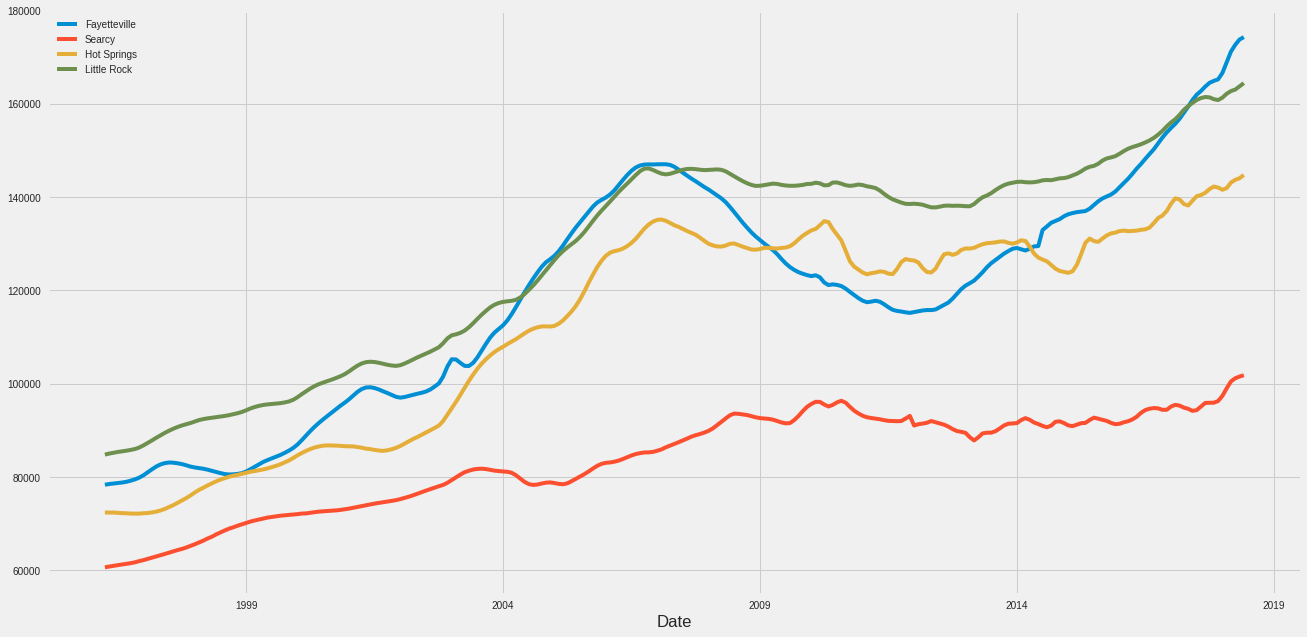

In [0]:
from matplotlib import pyplot

fayettevilleSeries = zillowMetro2.loc[zillowMetro2['Metro']=='Fayetteville',['Date','MedianHhValue']]
fayettevilleSeries = fayettevilleSeries.set_index('Date')
fayettevilleSeries = fayettevilleSeries.iloc[:,0]


hotSpringsSeries = zillowMetro2.loc[zillowMetro2['Metro']=='Hot Springs',['Date','MedianHhValue']]
hotSpringsSeries = hotSpringsSeries.set_index('Date')
hotSpringsSeries = hotSpringsSeries.iloc[:,0]


littleRockSeries = zillowMetro2.loc[zillowMetro2['Metro']=='Little Rock',['Date','MedianHhValue']]
littleRockSeries = littleRockSeries.set_index('Date')
littleRockSeries = littleRockSeries.iloc[:,0]


searcySeries = zillowMetro2.loc[zillowMetro2['Metro']=='Searcy',['Date','MedianHhValue']]
searcySeries = searcySeries.set_index('Date')
searcySeries = searcySeries.iloc[:,0]


fayettevilleSeries.plot().legend()
searcySeries.plot().legend()
hotSpringsSeries.plot().legend()
littleRockSeries.plot().legend(['Fayetteville','Searcy','Hot Springs','Little Rock'])


pyplot.show

## Correlations with the new data

Exploring the correlation between median house price, annual payroll and total employee counts

In [0]:
# reset the plot size
plt.rcParams['figure.figsize']=(30,10)

In [0]:
# Is there actually a correlation between the new Business Pattern features and the median house price?

zillowDF4[['MedianHhValue','EMP','PAYANN','DateYear','DateMonth']].corr()

,MedianHhValue,EMP,PAYANN,DateYear,DateMonth
MedianHhValue,1.000000,0.292309,0.365902,0.158784,-0.003058
EMP,0.292309,1.000000,0.969757,0.017350,-0.001089
PAYANN,0.365902,0.969757,1.000000,0.099627,-0.003842
DateYear,0.158784,0.017350,0.099627,1.000000,-0.058679
DateMonth,-0.003058,-0.001089,-0.003842,-0.058679,1.000000


In [0]:
# Quick check: is it better at the county, year level? this is techincally the way it came in

# Avg. median household value by county and year
avg_median = pd.DataFrame(zillowDF4.groupby(['CountyName','DateYear'])['MedianHhValue'].mean())
avg_median = avg_median.reset_index()

avg_EMP = pd.DataFrame(zillowDF4.groupby(['CountyName','DateYear'])['EMP'].max())
avg_EMP = avg_EMP.reset_index()

avg_PAYANN = pd.DataFrame(zillowDF4.groupby(['CountyName','DateYear'])['PAYANN'].max())
avg_PAYANN = avg_PAYANN.reset_index()

In [0]:
avg_median['EMP'] = avg_EMP['EMP']
avg_median['PAYANN'] = avg_PAYANN['PAYANN']

avg_median.corr()

# Definitively helps! There might be something there 
# both Payroll and employee count are, es expected, very correlated with each other

,DateYear,MedianHhValue,EMP,PAYANN
DateYear,1.000000,0.134095,0.015239,0.066816
MedianHhValue,0.134095,1.000000,0.366525,0.548825
EMP,0.015239,0.366525,1.000000,0.941810
PAYANN,0.066816,0.548825,0.941810,1.000000


In [0]:
# How much higher does this correlation get by zipcode?

zillowDF4[['MedianHhValue','EMP','PAYANN','DateYear','DateMonth']].corr()


,MedianHhValue,EMP,PAYANN,DateYear,DateMonth
MedianHhValue,1.000000,0.292309,0.365902,0.158784,-0.003058
EMP,0.292309,1.000000,0.969757,0.017350,-0.001089
PAYANN,0.365902,0.969757,1.000000,0.099627,-0.003842
DateYear,0.158784,0.017350,0.099627,1.000000,-0.058679
DateMonth,-0.003058,-0.001089,-0.003842,-0.058679,1.000000


In [0]:
# Like 2 minutes

start_time = time.time()

emplist = []
payannlist = []
zipClist = list(pd.unique(zillowDF4['ZipCode']))

for i in zipClist:
  temp_df = zillowDF4.loc[zillowDF4['ZipCode']==i,:]
  emplist.append(temp_df[['MedianHhValue','EMP','PAYANN','DateYear','DateMonth']].corr().iloc[1,0])
  payannlist.append(temp_df[['MedianHhValue','EMP','PAYANN','DateYear','DateMonth']].corr().iloc[2,0])
  
print("--- %s seconds ---" % (time.time() - start_time),"\n")

--- 101.45055437088013 seconds --- 



In [0]:
pd.DataFrame(list(zip(zipClist,emplist,payannlist)),columns=['zip','emp','pay']).describe()

# This is not veru informative, although the annual pay roll seems to correlate better on average than the employee counts
# This makes sense

,zip,emp,pay
count,15245.000000,14761.000000,14761.000000
mean,48010.355198,0.394576,0.774660
std,29121.614366,0.562809,0.312562
min,1001.000000,-0.964722,-0.979368
25%,22443.000000,-0.024413,0.772507
50%,46055.000000,0.619673,0.889432
75%,74872.000000,0.872384,0.940755
max,99901.000000,0.994042,0.996039


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Correlations by Zipcode for Annual Pay Roll')

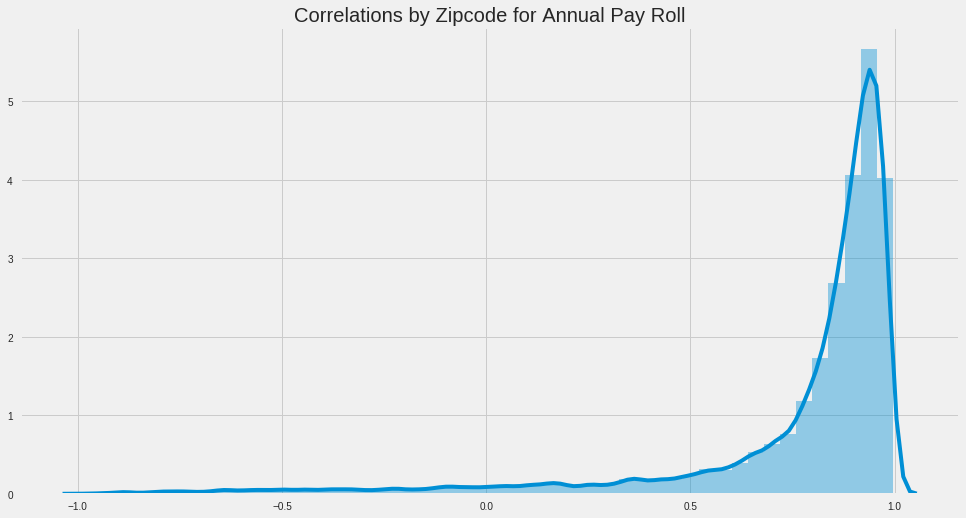

In [0]:
# Distribution of the correlations
sns.distplot([i for i in payannlist if str(i) != 'nan'])
plt.title('Correlations by Zipcode for Annual Pay Roll')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Correlations by Zipcode for Employee Count')

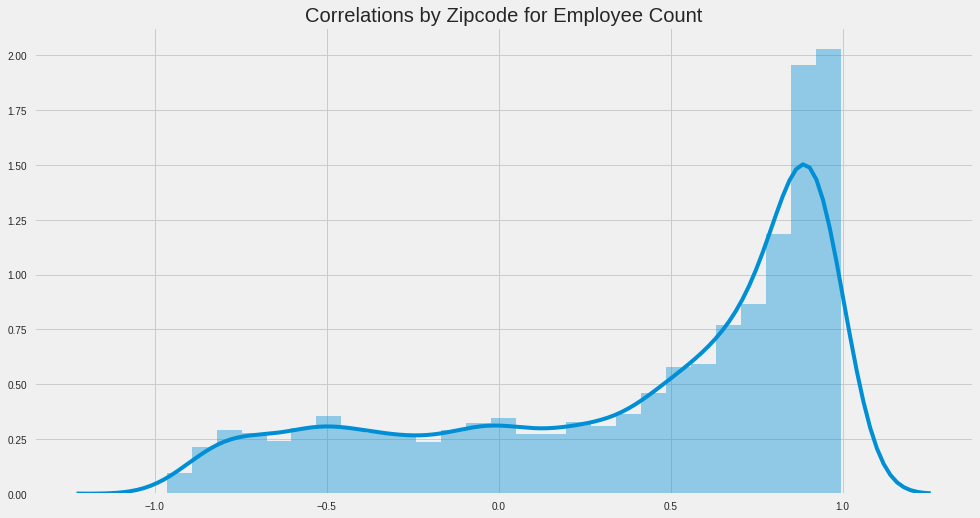

In [0]:
# Distribution of the correlations
sns.distplot([i for i in emplist if str(i) != 'nan'])
plt.title('Correlations by Zipcode for Employee Count')

## Narrowing down the search

Narrow the search with the broadest category possible: states. What states have shown a lot of growth in housing prices over the past 20 years?

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


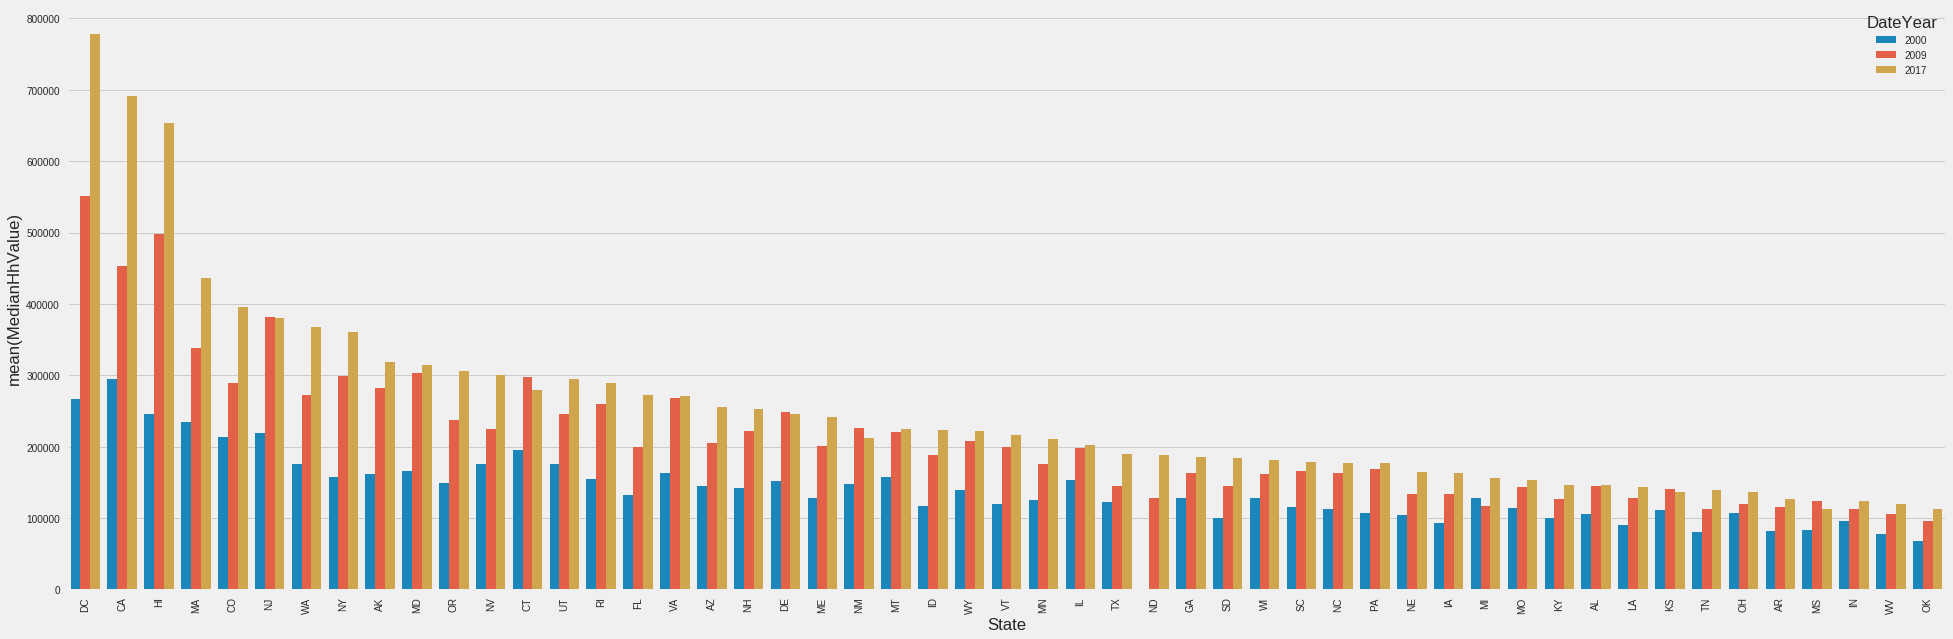

In [0]:
# Avg. median household value by state and year
avg_median_value = pd.DataFrame(zillowDF4.groupby(['State','DateYear'])['MedianHhValue'].mean().sort_values(ascending=False))
avg_median_value = avg_median_value.reset_index()

#avg_median_value.head()

plt.xticks(rotation=90)

sns.barplot(y="MedianHhValue",x="State",hue='DateYear',data=avg_median_value[avg_median_value['DateYear'].isin([2000,2009,2017])])


In [0]:
avg_median_value.head()

,State,DateYear,MedianHhValue
0,DC,2018,803865.740741
1,DC,2017,777941.666667
2,CA,2018,741432.925170
3,DC,2016,733084.259259
4,CA,2017,690947.476190


In [0]:
# Get the top 20 states by growth from 2009 to 2017

stateList = list(pd.unique(avg_median_value['State']))
percentChange = []

for state in stateList:
  new = float(avg_median_value.loc[(avg_median_value['State']==state)&(avg_median_value['DateYear']==2017),'MedianHhValue'])
  old = float(avg_median_value.loc[(avg_median_value['State']==state)&(avg_median_value['DateYear']==2009),'MedianHhValue'])
  percentChange.append((new-old)/old)

stateGrowth = pd.DataFrame(list(zip(stateList,percentChange)),columns=['State','Delta'])
stateGrowth = stateGrowth.sort_values(by='Delta',ascending=False )

pd.DataFrame(list(zip(stateGrowth['State'].map(states_reverse).reset_index(drop=True),stateGrowth['Delta'])),columns=['State2','Delta']).iloc[:25,:]

,State2,Delta
0,California,0.525145
1,North Dakota,0.471845
2,District of Columbia,0.412503
3,Colorado,0.369003
4,Florida,0.361417
5,Washington,0.352881
6,Nevada,0.336176
7,Michigan,0.334975
8,Hawaii,0.310994
9,Texas,0.304243


In [0]:
# To try and eliminate bias by just looking at one year (maybe it was a bad year?) I'll compare every year since 2008 against 2018 and get a unique list of all the states that ranked in the top 10

def top_states(start_year,end_year,top=10):
  stateList = list(pd.unique(avg_median_value['State']))
  percentChange = []

  for state in stateList:
    new = float(avg_median_value.loc[(avg_median_value['State']==state)&(avg_median_value['DateYear']==end_year),'MedianHhValue'])
    old = float(avg_median_value.loc[(avg_median_value['State']==state)&(avg_median_value['DateYear']==start_year),'MedianHhValue'])
    percentChange.append((new-old)/old)

  stateGrowth = pd.DataFrame(list(zip(stateList,percentChange)),columns=['State','Delta'])
  stateGrowth = stateGrowth.sort_values(by='Delta',ascending=False )

  return(stateGrowth['State'][:top])
  

In [0]:
topStates = []

for i in range(2008,2017):
  for state in list(top_states(i,2018,10)):
    topStates.append(state)
 
print('Total of',len(set(topStates)),'states in the list')
print(set(topStates))

Total of 20 states in the list
{'AZ', 'WA', 'MA', 'CO', 'UT', 'OR', 'HI', 'FL', 'CA', 'DC', 'TN', 'ID', 'GA', 'ND', 'RI', 'NE', 'SD', 'MI', 'TX', 'NV'}


In [0]:
# a function to plot boxplots for metro areas in a state over time

plt.rcParams['figure.figsize']=(30,10)

def metro_boxplot(state,year,month=False, swarm=False):
  
  try:
    zillowBox = zillowDF3[(zillowDF3['State']==state)&(zillowDF3['DateYear']==int(year))]
    title = 'State: '+state+' | Year: '+year
  except:
    zillowBox = zillowDF3[(zillowDF3['State']==state)&(zillowDF3['DateYear'].isin(year))]
    title = 'State: '+state+' | Year: '+str(min(year))+' to '+str(max(year))
  
  if month != False:
    zillowBox = zillowBox[zillowDF3['DateMonth']==int(month)]
    title = title+' | Month: '+month

  sorting_values = pd.DataFrame(zillowBox.groupby('Metro')['MedianHhValue'].median().sort_values(ascending=False))
  sorting_values = sorting_values.reset_index()
  
  plt.xticks(rotation=90)
  sns.boxplot(x="Metro", y="MedianHhValue", data=zillowBox, order=sorting_values['Metro']).set_title(title)
  
  if swarm != False:
    sns.swarmplot(x="Metro", y="MedianHhValue", data=zillowBox, order=sorting_values['Metro'],color="grey")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


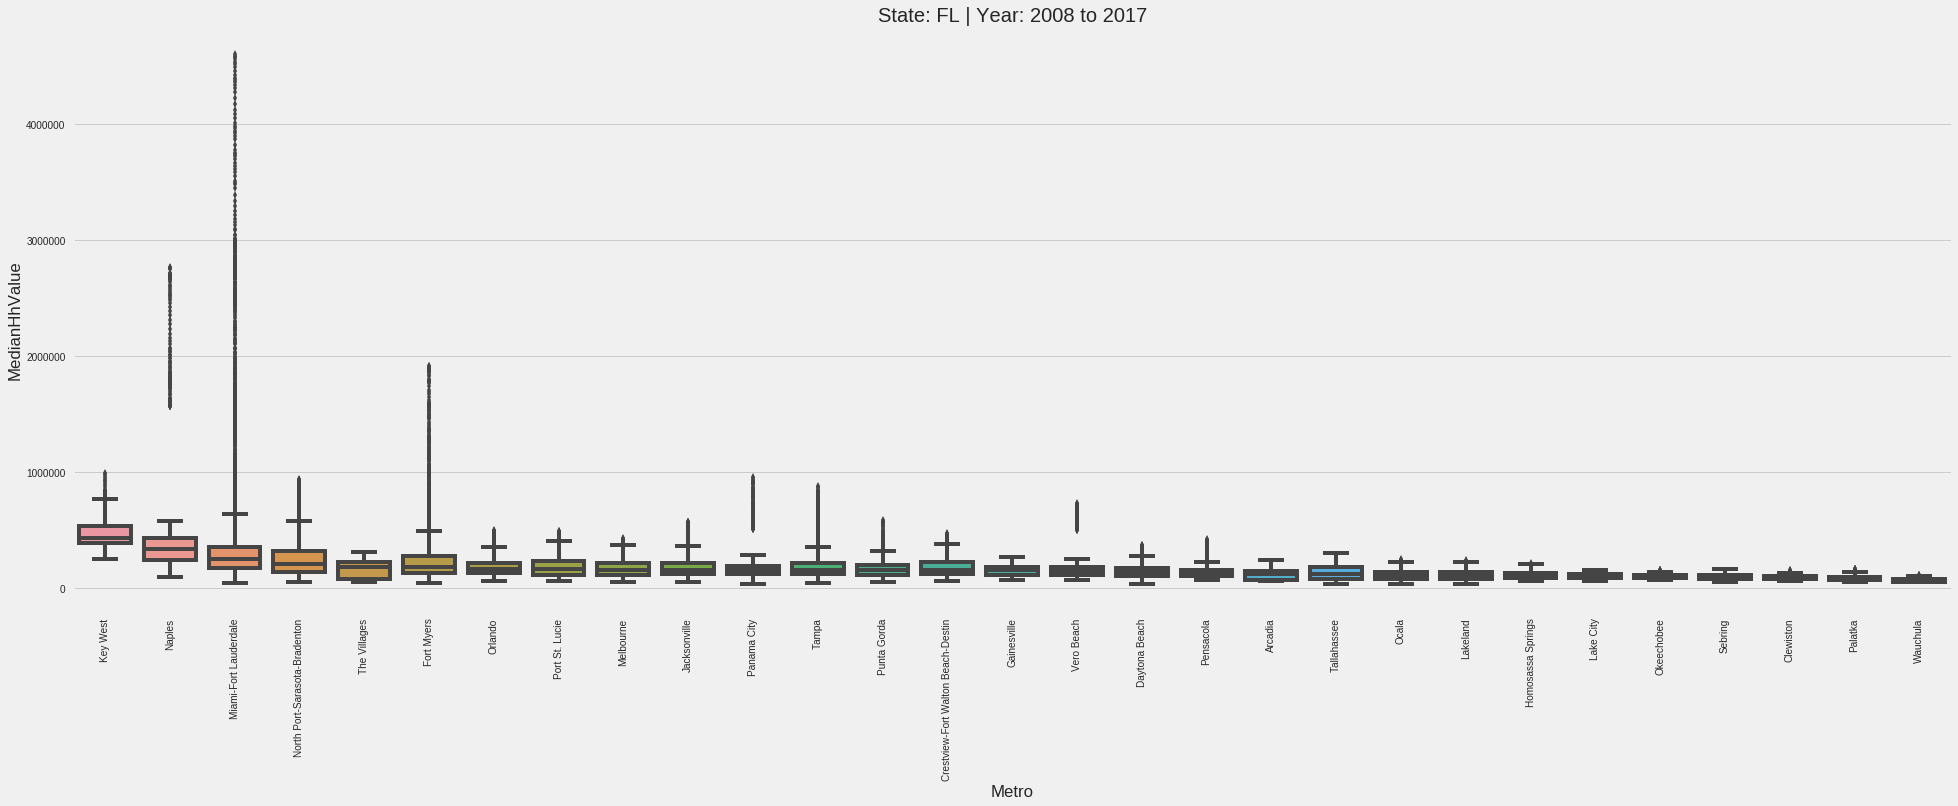

In [0]:
some_years = [i for i in range(2008,2018)]

metro_boxplot('FL',some_years)

In [0]:
def metro_boxplot_series(metro,state_abv):
  
  dataset = zillowMetro.loc[(zillowMetro['State']==state_abv)&(zillowMetro['Metro']==metro),]
  
  title = 'State: '+state_abv+'| Metro: '+metro
  
  plt.xticks(rotation=90)
  sns.boxplot(x="DateYear", y="MedianHhValue", data=dataset)
  sns.swarmplot(x="DateYear", y="MedianHhValue", data=dataset,color="grey").set_title(title)
  

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


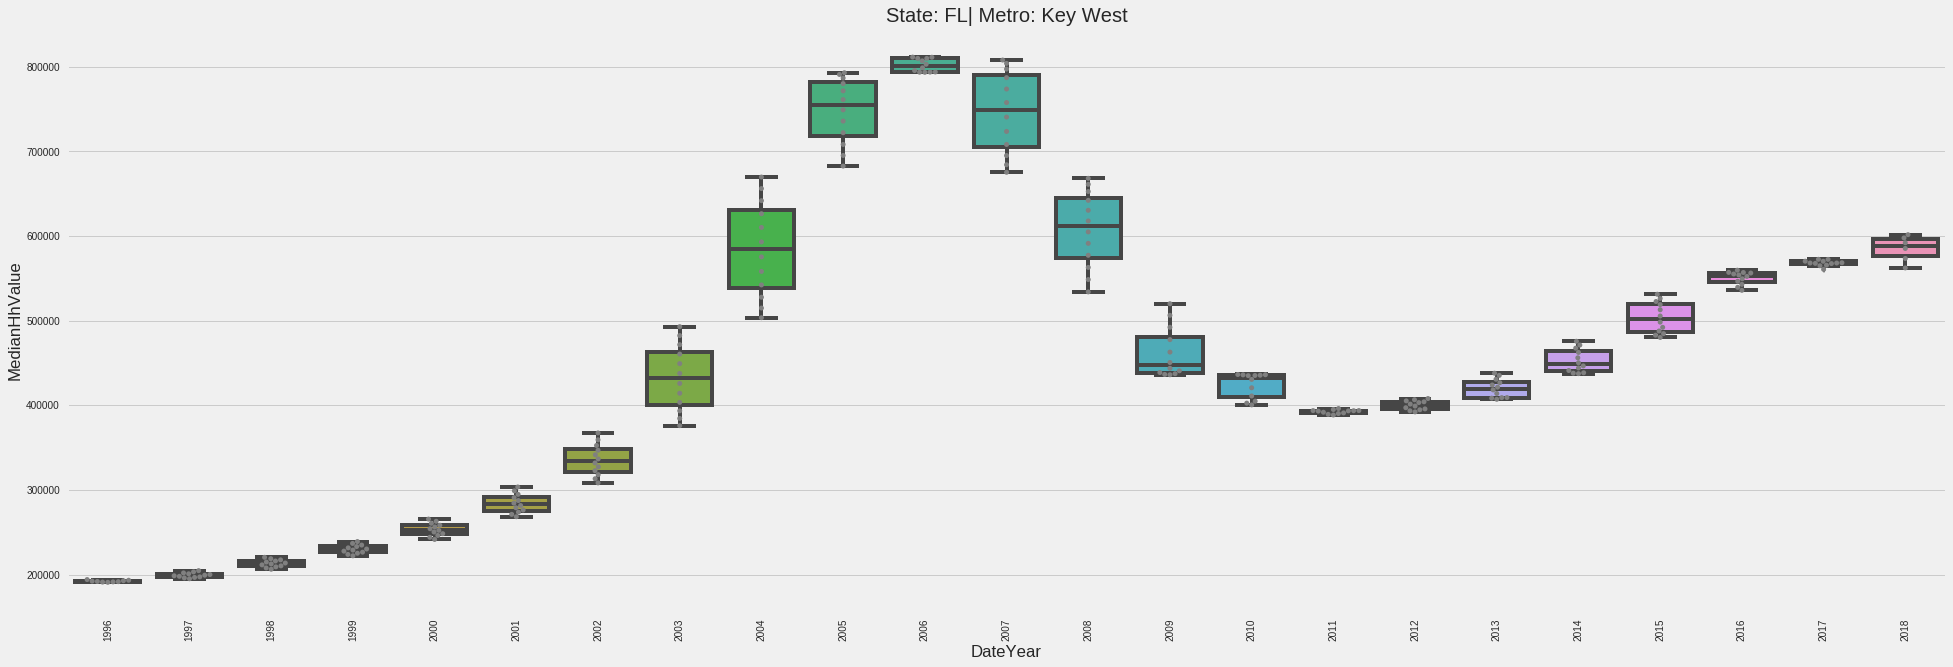

In [0]:
# A boxplot of the montlhy values by year could give us insight into which years varied a lot by month

metro_boxplot_series('Key West','FL')

# Modeling

Forecasting future values with Prophet

In [0]:
# Hold 2017 and 2018 values to test the model

zillowTrain = zillowDF4[zillowDF4['DateYear']<2017]

zillowTest = zillowDF4[zillowDF4['DateYear']>2016]

In [0]:
list(zillowDF4)

['ZipCode',
 'City',
 'State',
 'Metro',
 'CountyName',
 'SizeRank',
 'Date',
 'MedianHhValue',
 'DateYear',
 'DateMonth',
 'EMP',
 'PAYANN']

In [0]:
testSeries = zillowTrain.loc[zillowTrain['ZipCode']==60614,['Date','MedianHhValue']]
testSeries = testSeries.set_index('Date')
testSeries = testSeries.iloc[:,0]

In [0]:
# Rename columns for prophet
# Prophet limits the naming convention of the input columns to be ds (date) and y (the value)

prophetTest = testSeries.to_frame().reset_index()

prophetTest = prophetTest.rename(index=str, columns={"MedianHhValue": "y", "Date": "ds"})


In [0]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

test_model = Prophet(interval_width=0.95)
test_model.fit(prophetTest)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future_dates = test_model.make_future_dataframe(periods=19, freq='M')
future_dates.tail()

,ds
263,2018-02-28
264,2018-03-31
265,2018-04-30
266,2018-05-31
267,2018-06-30


In [0]:
# MODEL

forecast = test_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
263,2018-02-28,1.396471e+06,1.336234e+06,1.452422e+06
264,2018-03-31,1.392701e+06,1.331499e+06,1.456437e+06
265,2018-04-30,1.393800e+06,1.329037e+06,1.456604e+06
266,2018-05-31,1.397505e+06,1.327945e+06,1.468625e+06
267,2018-06-30,1.401857e+06,1.325678e+06,1.475841e+06


In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt


# len(future_dates[-18:])==len(zillowTest.loc[zillowTest['ZipCode']==60614,['Date']])

rms = sqrt(mean_squared_error(zillowTest.loc[zillowTest['ZipCode']==60614,'MedianHhValue'], forecast.iloc[-18:,15]))

print('RMSE:',rms)



RMSE: 62438.41734054824


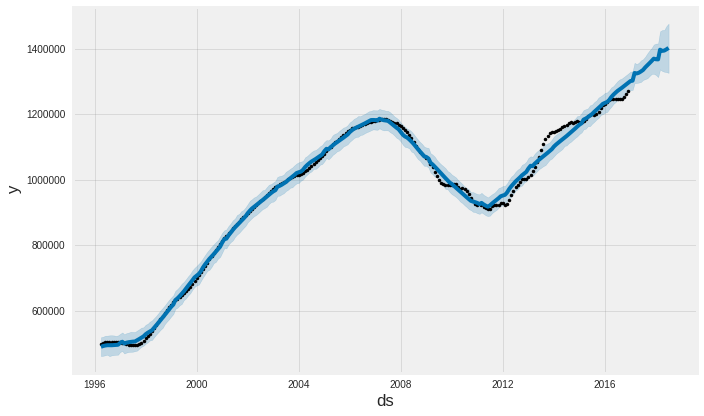

In [0]:
test_model.plot(forecast);

# Zoom in
#test_model.plot(forecast[(forecast['ds'] > '2010-01-01')]);

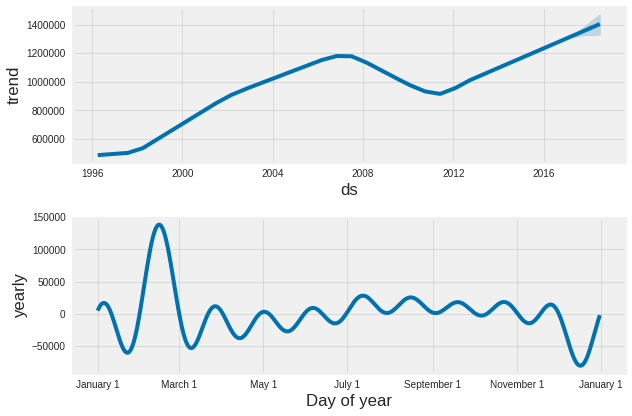

In [0]:
test_model.plot_components(forecast);

In [0]:
# A pipeline for RMSE on the prophet predictions
# It is using the zillow train DF

def predicitonRMSE(zipcode,periods = 19, printRMSE=False, outputRMSE=True):
  
  to_pred = zillowTrain.loc[zillowTrain['ZipCode']==zipcode,['Date','MedianHhValue']]
  to_pred = to_pred.set_index('Date')
  to_pred = to_pred.iloc[:,0]
  to_pred = to_pred.to_frame().reset_index()
  to_pred = to_pred.rename(index=str, columns={"MedianHhValue": "y", "Date": "ds"})

  test_model = Prophet(interval_width=0.95,weekly_seasonality=False,daily_seasonality=False)
  test_model.fit(to_pred)

  future_dates = test_model.make_future_dataframe(periods=periods, freq='M')
  forecast = test_model.predict(future_dates)
  
  rms = sqrt(mean_squared_error(zillowTest.loc[zillowTest['ZipCode']==zipcode,'MedianHhValue'], forecast.iloc[-(periods-1):,15]))
  
  if printRMSE != False:
    print('RMSE:',rms)
    
  if outputRMSE == True:
    return(forecast,rms)
  else:
    return(forecast)
    

In [0]:
zip60614 = predicitonRMSE(60614, printRMSE=True)

RMSE: 62438.41734054824


In [0]:
# Could I do better if I passed the data as yearly? This could be a valid downsampling method
# I want to check before running the loop

zillowYear = zillowDF4

zillowYear = zillowYear.groupby(['ZipCode','DateYear'], as_index=False)['MedianHhValue'].mean()

zillowYear['Date'] = pd.to_datetime(zillowYear['DateYear'], format='%Y')

zillowYear.head()

,ZipCode,DateYear,MedianHhValue,Date
0,1001,1996,112222.222222,1996-01-01
1,1001,1997,113241.666667,1997-01-01
2,1001,1998,116516.666667,1998-01-01
3,1001,1999,120200.000000,1999-01-01
4,1001,2000,126225.000000,2000-01-01


In [0]:
zillowTrain2 = zillowYear[zillowYear['DateYear']<2012]

zillowTest2 = zillowYear[zillowYear['DateYear']>=2012]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.0.


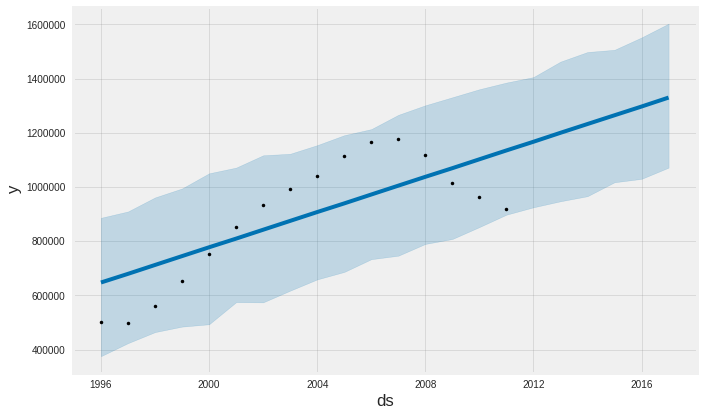

In [0]:
to_pred = zillowTrain2.loc[zillowTrain2['ZipCode']==60614,['Date','MedianHhValue']]
to_pred = to_pred.set_index('Date')
to_pred = to_pred.iloc[:,0]
to_pred = to_pred.to_frame().reset_index()
to_pred = to_pred.rename(index=str, columns={"MedianHhValue": "y", "Date": "ds"})

test_model = Prophet(interval_width=0.95)
test_model.fit(to_pred)

future_dates = test_model.make_future_dataframe(periods=6, freq='Y')
forecast = test_model.predict(future_dates)

test_model.plot(forecast);

In [0]:
# It seems like the prediction for years gets too simplistic and its way too affected by how much training data I feed it

rms = sqrt(mean_squared_error(zillowTest2.loc[zillowTest2['ZipCode']==60614,'MedianHhValue'], forecast.iloc[-7:,15]))
  
print('RMSE:',rms)

RMSE: 75229.38158373172


In [0]:
zipList = list(pd.unique(zillowTrain['ZipCode']))
print('There is a total of',len(zipList),'zipcodes in the dataset')

There is a total of 15245 zipcodes in the dataset


In [0]:
# 759.8757290840149 seconds

#start_time = time.time()

#forecastList = []
#rmseList = []


#for zipcode in zipList[:100]:
#  pred = predicitonRMSE(zipcode,outputRMSE=True)
#  forecastList.append(predicitonRMSE(zipcode)[0])
#  rmseList.append(predicitonRMSE(zipcode)[1])
  
  
#print("--- %s seconds ---" % (time.time() - start_time))

In [0]:
# Found an article that talked about running prophet in parallel, let's try!
# Source: https://medium.com/devschile/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245

from multiprocessing import Pool, cpu_count

#start_time = time.time()

#p = Pool(cpu_count())
#predictions = list(p.imap(predicitonRMSE, zipList[:100]))
#p.close()
#p.join()

#print("--- %s seconds ---" % (time.time() - start_time))

# 201.9159984588623 seconds
# SO MUCH FASTER!

Using the parallel process I might be able to run the forecast for almost all the zipcodes. I am still going to have to do a little downsampling because I calculate it might take around 10 hours for all of them.

In [0]:
# There seems to be some zipcodes with very high RMSE (250k+) but most of them are in the smallest bin, this is good!
# There is some scary outliers in there above 15 MM but since RMSE is in the same units as the prediction, it might just be an extremely expensive zip code (hopefully)

# sns.distplot(rmseList)

In [0]:
# Adjust the function so it uses the full dataset and projects 5 years into the future

def prophet_pred(zipcode,periods = 66):
  
  dataset = zillowDF4[zillowDF4['MedianHhValue'].notna()]
  
  to_pred = dataset.loc[dataset['ZipCode']==zipcode,['Date','MedianHhValue']]
  to_pred = to_pred.set_index('Date')
  to_pred = to_pred.iloc[:,0]
  to_pred = to_pred.to_frame().reset_index()
  to_pred = to_pred.rename(index=str, columns={"MedianHhValue": "y", "Date": "ds"})

  test_model = Prophet(interval_width=0.95,weekly_seasonality=False,daily_seasonality=False)
  test_model.fit(to_pred)

  future_dates = test_model.make_future_dataframe(periods=periods, freq='M')
  forecast = test_model.predict(future_dates)
  
  forecast['ZipCode'] = zipcode

  return(forecast)

# Choosing

Downsampling for the more promising states and projecting 5 years into the future.

In [0]:
topStates = list(set(topStates))


zillowDF5 = zillowDF4[zillowDF4['State'].isin(topStates)]


zipList2 = list(pd.unique(zillowDF5['ZipCode']))

print('There is a total of',len(zipList2),'zipcodes in the choosing set')

There is a total of 6433 zipcodes in the choosing set


In [0]:
# About 4 hours
# The google auth client expired while it ran overnight but I managed to save it before the runtime diconnected

#start_time = time.time()

#p = Pool(cpu_count())
#predictions = list(p.imap(prophet_pred, zipList2))
#p.close()
#p.join()

#print("--- %s seconds ---" % (time.time() - start_time))



#finalpred = pd.concat(predictions)

#finalpred.to_csv('finalpred.csv', sep=',')

#file = drive.CreateFile({'parents':[{u'id': '1vKh_qhEB8318mR0IwFjubX53yiNl79yX'}]})
#file.SetContentFile("finalpred.csv")
#file.Upload()


In [0]:
link = 'https://drive.google.com/open?id=19CU1edsU60cZ1CxO-1wksA7ExagKdAOF' # The shareable link
fluff, id = link.split('=')

# Storing the file into a dataframe
downloaded = drive.CreateFile({'id':id});
downloaded.GetContentFile('Filename.csv');

# Move the file into a data frame
finalpred = pd.read_csv('Filename.csv');


INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/19CU1edsU60cZ1CxO-1wksA7ExagKdAOF?alt=json


In [0]:
#Turning ds into datetime and confirming all the zipcodes are there

finalpred['ds'] = pd.to_datetime(finalpred['ds'])


len(pd.unique(finalpred['ZipCode'])) == len(zipList2)

True

In [0]:
# A dateyear column so I can aggregate to the year

finalpred2 = finalpred

Year = []

for i in finalpred2['ds']:
  Year.append(i.year)
  
finalpred2['DateYear'] = Year

finalpred2 = finalpred2.groupby(['ZipCode','DateYear'], as_index=False)['yhat'].mean()

finalpred2.head()


,ZipCode,DateYear,yhat
0,1001,1996,111826.057326
1,1001,1997,113627.930106
2,1001,1998,116419.409798
3,1001,1999,120220.221833
4,1001,2000,126280.699536


In [0]:
# Similar to what I did before, lets get the top 10 zipcodes to invest and deep dive into their performance to see which one is best

# Get the top 10 states by growth from 2018 to 2022

start_time = time.time()

ziplist3 = list(pd.unique(finalpred2['ZipCode']))
percentChange = []

for zipcode in ziplist3:
  new = float(finalpred2.loc[(finalpred2['ZipCode']==zipcode)&(finalpred2['DateYear']==2022),'yhat'])
  old = float(finalpred2.loc[(finalpred2['ZipCode']==zipcode)&(finalpred2['DateYear']==2018),'yhat'])
  percentChange.append((new-old)/old)

zipGrowth = pd.DataFrame(list(zip(ziplist3,percentChange)),columns=['ZipCode','Delta'])
zipGrowth = zipGrowth.sort_values(by='Delta',ascending=False )


print("--- %s seconds ---" % (time.time() - start_time))

zipGrowth.head()

--- 14.169682025909424 seconds ---


,ZipCode,Delta
2164,48157,0.857248
642,30315,0.829311
901,32145,0.691180
5383,94525,0.678605
5714,95815,0.663358


In [0]:
# Enrich zipGrowth DF with state names, metro areast, etc so we can tell exaclty where these zipcodes are

extra_data = zillowDF5[zillowDF5['DateYear']==2018].iloc[:,:4].drop_duplicates()

zipGrowth2 = pd.merge(zipGrowth, extra_data,  how='left', left_on='ZipCode', right_on ='ZipCode')

# just reorganizing columns for my own sanity
zipGrowth2 = zipGrowth2.iloc[:,[3,4,2,0,1]]

zipGrowth2.iloc[:10,[2,1,0,3,4]]

# According to these intial findings, the SREIT should invest in Luna Pier, MI; Atlanta, GA; and Jacksonville, FL. 

,City,Metro,State,ZipCode,Delta
0,Luna Pier,Monroe,MI,48157,0.857248
1,Atlanta,Atlanta,GA,30315,0.829311
2,Hastings,Jacksonville,FL,32145,0.691180
3,Crockett,San Francisco,CA,94525,0.678605
4,Sacramento,Sacramento,CA,95815,0.663358
5,Denver,Denver,CO,80216,0.659454
6,Watertown,Nashville,TN,37184,0.656282
7,Lake Wales,Lakeland,FL,33855,0.652097
8,Santa Rosa,Brownsville,TX,78593,0.612406
9,North Las Vegas,Las Vegas,NV,89030,0.579361


#Validating

This is mostly going to be a qualitative validation, looking at the trends of these top 10 states and seeing if any of them seem particularly risky or if the RMSE on the train/test for pre-2017 comes up relatively too high

## Boxplot series

How much are these prices swining each year?

In [0]:
# How mnay zipcodes are in these cities?

number_of_zipcodes('Atlanta','GA')

# Luna Pier for example only has one, but Atlanta has 13 other zipcodes in it

13

In [0]:
# I think these boxplot series give a lot of information in one graph

def zipcode_boxplot_series(zipcode):
  
  plt.rcParams['figure.figsize']=(15,8)
  
  zipcode = int(zipcode)
  
  dataset = zillowDF5.loc[(zillowDF5['ZipCode']==zipcode),]
  
  dataset = dataset[dataset['MedianHhValue'].notna()]
  
  city = str(zillowDF5.loc[(zillowDF5['ZipCode']==zipcode),'City'].iloc[0])
  state = str(zillowDF5.loc[(zillowDF5['ZipCode']==zipcode),'State'].iloc[0])
  
  title = 'Zipcode: '+str(zipcode)+' | '+city+', '+state
  
  plt.xticks(rotation=90)
  sns.boxplot(x="DateYear", y="MedianHhValue", data=dataset)
  sns.swarmplot(x="DateYear", y="MedianHhValue", data=dataset,color="grey").set_title(title)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


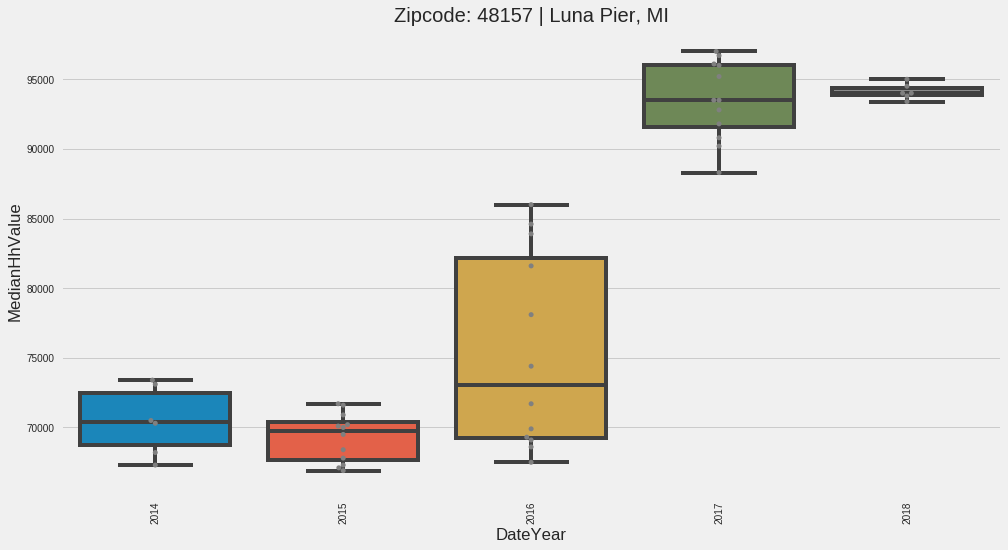

In [0]:
zipcode_boxplot_series(zipGrowth2['ZipCode'][0])

# Median value in Luna Pier does seem to have increased rapidly over the past few years, though it seems like it stabilized in 2018

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


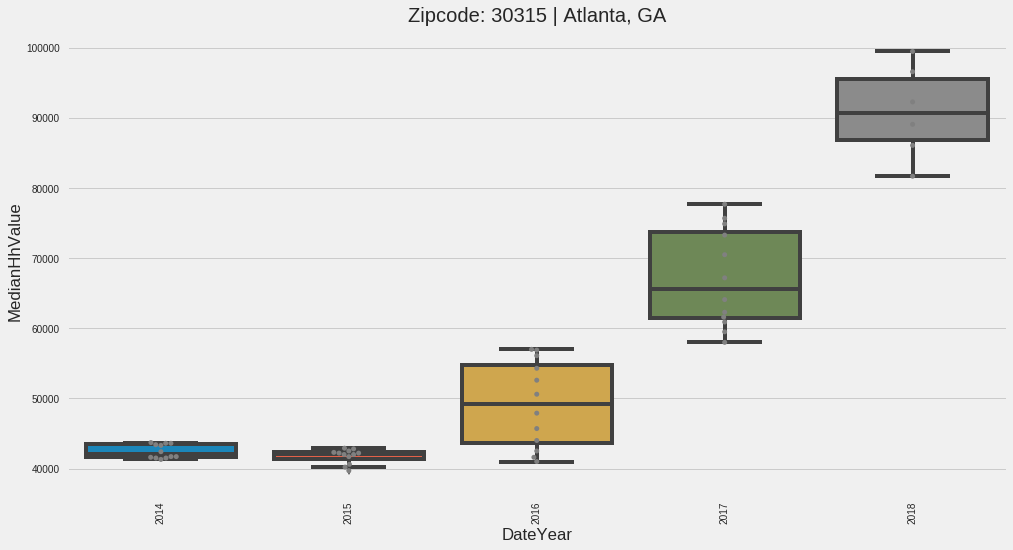

In [0]:
zipcode_boxplot_series(zipGrowth2['ZipCode'][1])

# These suburbs in Atlanta also seem to have rapid growth over the past few years. Something in common  with Luna pier is that it seems like they are new communities (data is starting in 2014)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


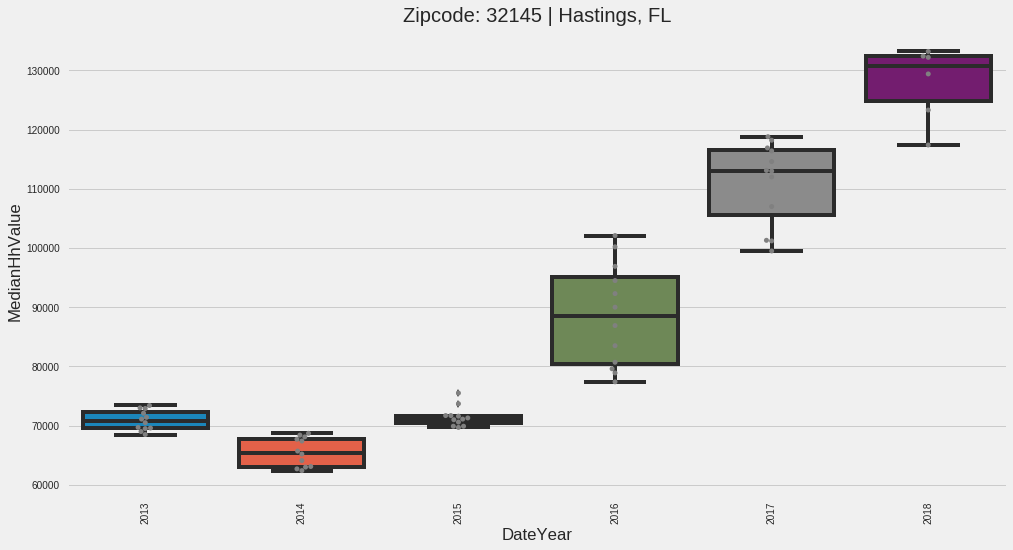

In [0]:
zipcode_boxplot_series(zipGrowth2['ZipCode'][2])

# Another new community, Hastings FL also shows rapid growth in the data we have available

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


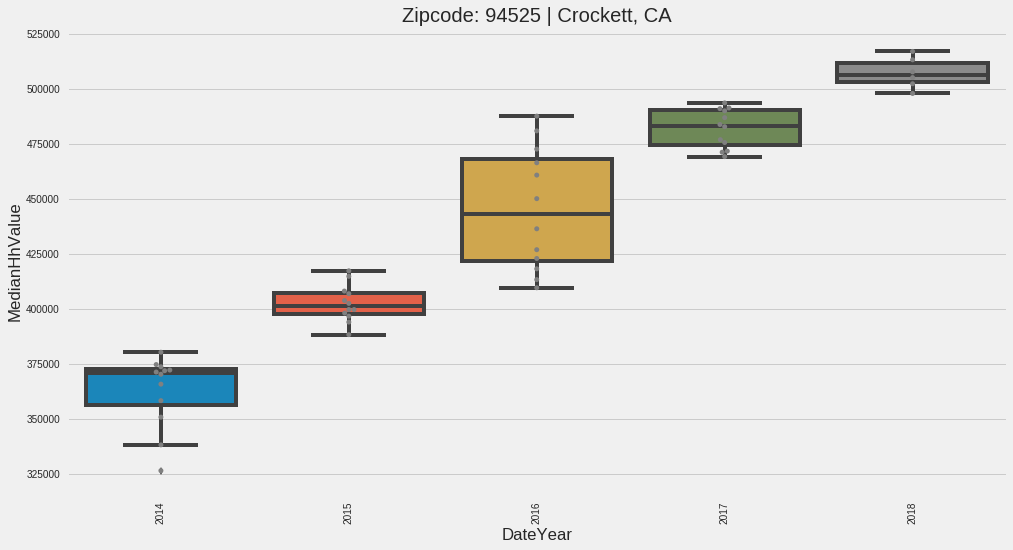

In [0]:
zipcode_boxplot_series(zipGrowth2['ZipCode'][3])

## Model double check

Prophet graphs and RMSE for the best zipcodes selected. Is it too high? Which ones are the less risky precitions?

In [0]:
# I'm going to check the one for the top 100

# 351.1399178504944 seconds

start_time = time.time()

forecastList = []
rmseList = []


for zipcode in zipGrowth2['ZipCode'][:50]:
  pred = predicitonRMSE(zipcode,outputRMSE=True)
  forecastList.append(predicitonRMSE(zipcode)[0])
  rmseList.append(predicitonRMSE(zipcode)[1])
  
  
print("--- %s seconds ---" % (time.time() - start_time))

INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.


--- 351.1399178504944 seconds ---


In [0]:
pd.DataFrame(list(zip(zipGrowth2['ZipCode'][:50],rmseList))).iloc[:10,]

# This is not going to be very objective since the prices varies so much by state...

,0,1
0,48157,25859.867992
1,30315,4711.814209
2,32145,8357.933584
3,94525,130683.316291
4,95815,10379.431939
5,80216,36264.816844
6,37184,35304.737747
7,33855,6411.783512
8,78593,5107.855434
9,89030,4231.995235


In [0]:
# Adjust the function from before to show the prophet plots

def prophet_plot(zipcode,periods = 66):
  
  city = str(zillowDF4.loc[(zillowDF4['ZipCode']==zipcode),'City'].iloc[0])
  state = str(zillowDF4.loc[(zillowDF4['ZipCode']==zipcode),'State'].iloc[0])
  
  title = city+', '+state
  
  dataset = zillowDF4[zillowDF4['MedianHhValue'].notna()]
  
  to_pred = dataset.loc[dataset['ZipCode']==zipcode,['Date','MedianHhValue']]
  to_pred = to_pred.set_index('Date')
  to_pred = to_pred.iloc[:,0]
  to_pred = to_pred.to_frame().reset_index()
  to_pred = to_pred.rename(index=str, columns={"MedianHhValue": "y", "Date": "ds"})

  test_model = Prophet(interval_width=0.95,weekly_seasonality=False,daily_seasonality=False)
  test_model.fit(to_pred)

  future_dates = test_model.make_future_dataframe(periods=periods, freq='M')
  forecast = test_model.predict(future_dates)
  
  print(title,'\n')
  test_model.plot(forecast);
  test_model.plot_components(forecast);

Luna Pier, MI 



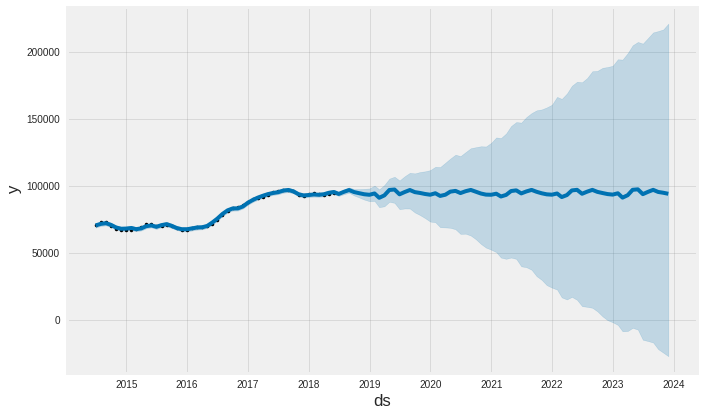

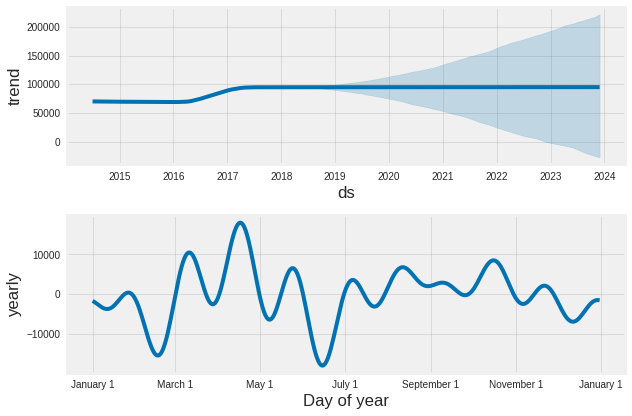

In [0]:
# The best zipcode 

prophet_plot(zipGrowth2['ZipCode'][0])

Atlanta, GA 



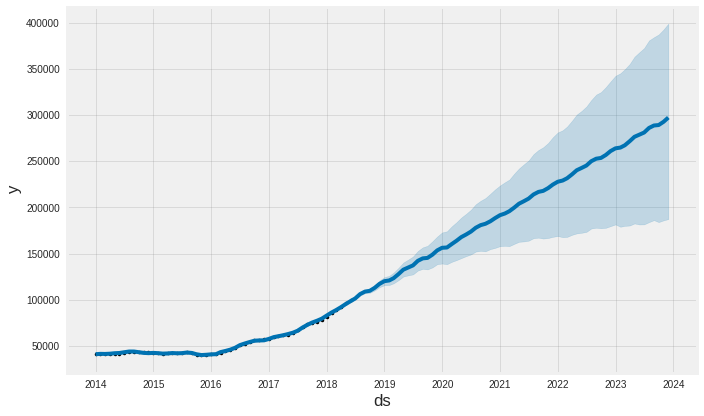

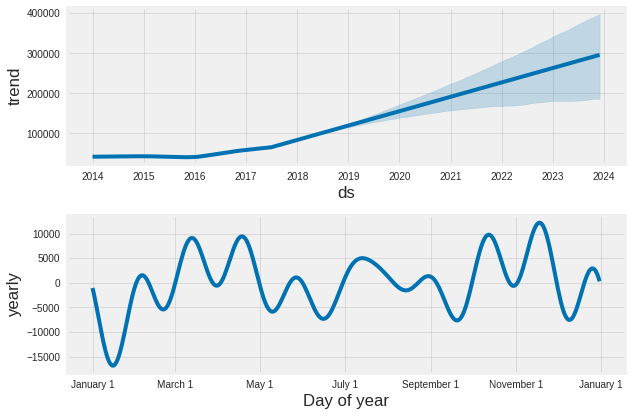

In [0]:
# The second best

prophet_plot(zipGrowth2['ZipCode'][1])

Hastings, FL 



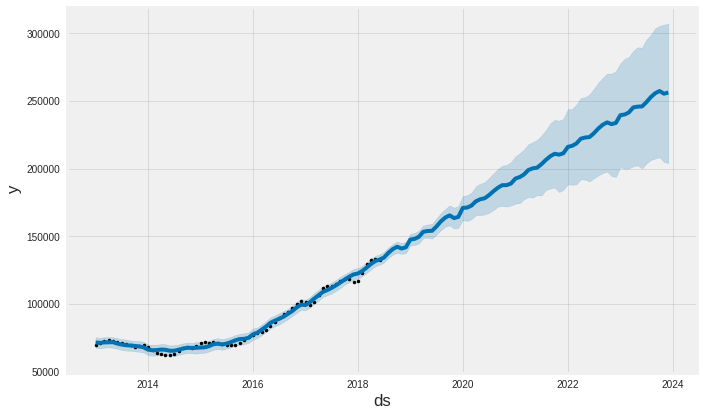

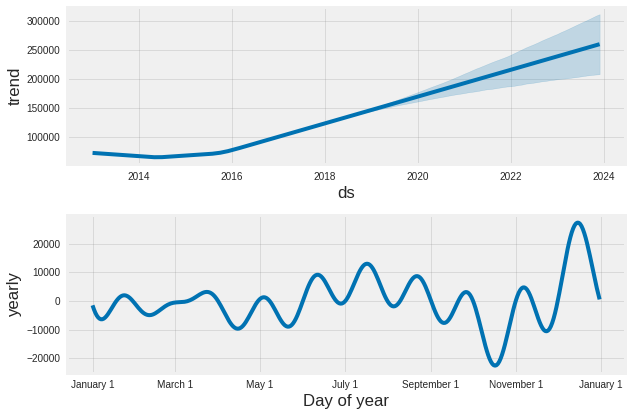

In [0]:
# The third best

prophet_plot(zipGrowth2['ZipCode'][2])

Crockett, CA 



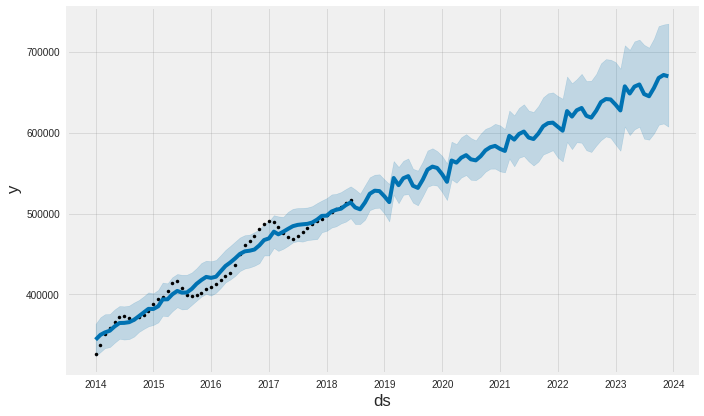

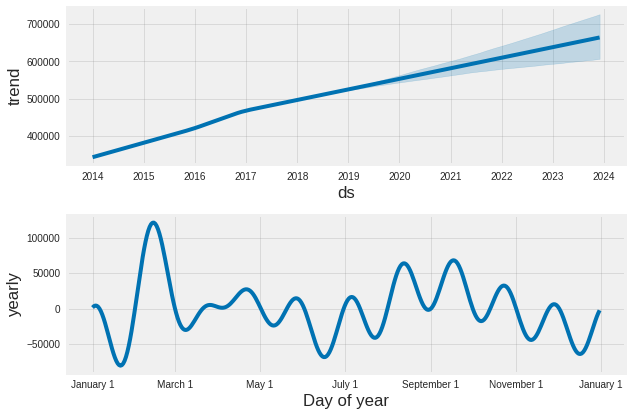

In [0]:
# The fouth best

prophet_plot(zipGrowth2['ZipCode'][3])

Denver, CO 



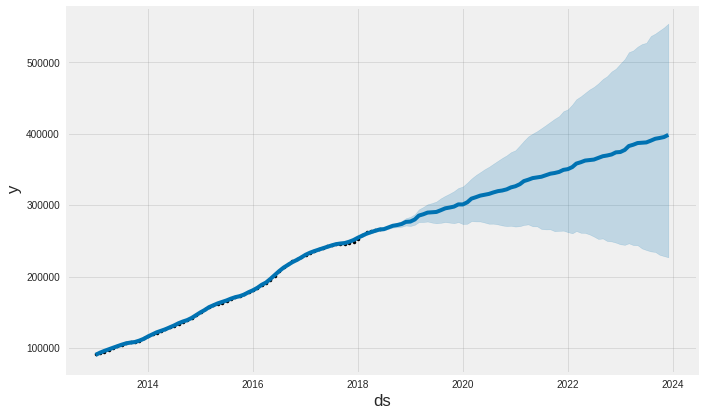

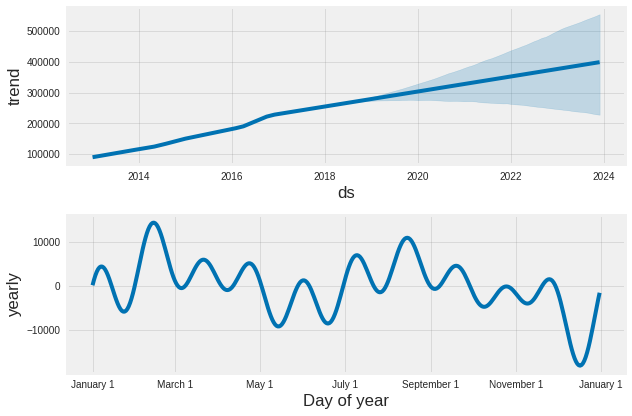

In [0]:
# The fifth best

prophet_plot(zipGrowth2['ZipCode'][5])

## The Map

In [0]:
# Bring in this package to get lattitude and longitude for a map plot

!pip install -U -q uszipcode

from uszipcode import SearchEngine

In [0]:
!apt install proj-bin libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
!pip install --user git+https://github.com/matplotlib/basemap.git

  Cloning https://github.com/matplotlib/basemap.git to /tmp/pip-req-build-4dkvyfww
  Stored in directory: /tmp/pip-ephem-wheel-cache-okvd3bc6/wheels/3f/f3/56/de548b66967d0d661612b7618022e2c0d4b86b9a638cf6ccf3
Successfully built basemap


In [0]:
# Parse the result to get lat and long

search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database

zipcode = search.by_zipcode(zipGrowth2['ZipCode'][0])

zipcode = zipcode.to_dict()

print(zipcode['lat'])
print(zipcode['lng'])

41.82
-83.44


In [0]:
# Loop through and get the geo points (~ 32 sec)

start_time = time.time()

long = []
lat= []

for zippy in zipGrowth2['ZipCode']:
  search = SearchEngine(simple_zipcode=True)
  zipcode = search.by_zipcode(zippy)
  zipcode = zipcode.to_dict()
  long.append(zipcode['lng'])
  lat.append(zipcode['lat'])
  
print("--- %s seconds ---" % (time.time() - start_time))

len(long) == len(zipGrowth2)
  

--- 30.895390510559082 seconds ---


True

In [0]:
zipGrowth2['lat'] = lat
zipGrowth2['long'] = long


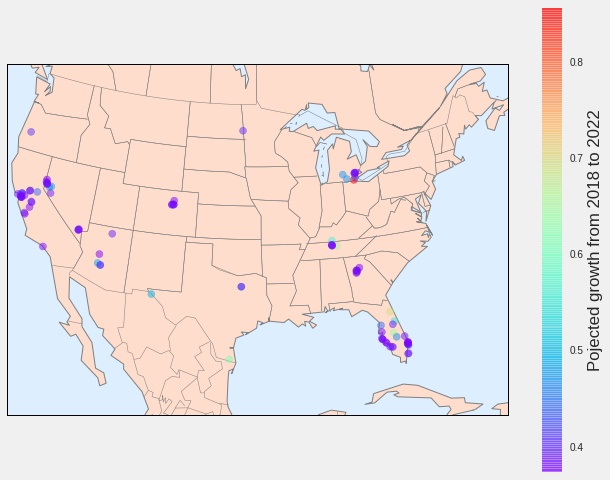

In [0]:
from mpl_toolkits.basemap import Basemap

zipGrowth3 = zipGrowth2.iloc[:100,:]

lat = zipGrowth3['lat'].values
lon = zipGrowth3['long'].values
growth = zipGrowth3['Delta'].values


# 1. Draw the map background
fig = plt.figure(figsize=(10, 8))
m = Basemap(projection='lcc', resolution='c', 
             lat_0=37, lon_0=-95,
            width=5000000, height=3500000)
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.drawcoastlines(color='gray')
m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")

# 2. scatter city data, with color reflecting growth
m.scatter(lon, lat, latlon=True,c=growth,cmap='rainbow', alpha=0.5,zorder=10)


plt.colorbar(label='Pojected growth from 2018 to 2022');